<h2>Formula 1 Grand Prix result prediction</h2>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV,train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error,mean_absolute_error
import pickle


plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [7]:
results = pd.read_csv(r'data/results.csv')
races = pd.read_csv(r'data/races.csv')
qualifyings = pd.read_csv(r'data/qualifying.csv')
drivers = pd.read_csv(r'data/drivers.csv')
constructors = pd.read_csv(r'data/constructors.csv')
circuits = pd.read_csv(r'data/circuits.csv')
status = pd.read_csv(r'data/status.csv')
laptimes = pd.read_csv(r'data/lap_times.csv')


countries = pd.read_csv(r'data/countries/countries.csv')

In [8]:
df1 = pd.merge(races,results,how='left',on=['raceId'], suffixes=('_race', '_result'))
df2 = pd.merge(df1,qualifyings,how='left',on=['raceId','driverId','constructorId'], suffixes=('', '_qualifying'))
df3 = pd.merge(df2,drivers,how='left',on=['driverId'], suffixes=('', '_driver'))
df4 = pd.merge(df3,constructors,how='left',on=['constructorId'], suffixes=('', '_constructor'))
df5 = pd.merge(df4,circuits,how='left',on=['circuitId'], suffixes=('', '_circuit'))
df6 = pd.merge(df5,status,how='left',on=['statusId'], suffixes=('', '_status'))
df7 = pd.merge(df6,laptimes,how='left',on=['raceId','driverId'], suffixes=('', '_laptime'))

In [9]:

data = df7;
#drop the columns which are not important


data = df7.drop(['raceId',  'round', 'circuitId', 'name', 'time_race',
       'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'constructorId', 'number',  'position',
       'positionText','positionOrder', 'points', 'time_result',
        'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_qualifying',
       'position_qualifying', 'q1', 'q2', 'q3', 'driverRef', 'number_driver',
       'code',   'url_driver',
       'constructorRef', 
       'url_constructor', 'circuitRef',  'location',
       'lat', 'lng', 'alt', 'url_circuit', 'lap', 'position_laptime','time'
      ],axis=1)

In [10]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData = testData[(testData['year'] == 2020) & (testData['name_circuit'] == 'Bahrain International Circuit')] 

#export test data to csv
#testData.to_csv('testData.csv', index=False)


In [11]:
#rename the columns
data.rename(columns={'name':'race_name','grid':'quali_pos','name_constructor':'constructor',
                     'nationality':'driver_nationality','nationality_constructor':'constructor_nationality', 'name_circuit' :'circuit', 'country': 'country_circuit', 'type': 'type_circuit'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
#drop forename columns and surname columns
data = data.drop(['forename','surname'],axis=1)
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_19788\3653828124.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


In [12]:
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driverId')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driverId', how='left')
data = data.drop(['driverId'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [13]:
#create a rain column where if the weather is 'Rain or 'Changeable' or 'Very changeable' then 1 else 0
data['rain'] = data['weather'].apply(lambda x: 1 if x in ['Rain', 'Changeable', 'Very changeable'] else 0)
#drop the weather column
data = data.drop(['weather'],axis=1)

In [14]:
#select all data from 1980
data = data[data['year']>=1980]
#get first nationality only


In [15]:
print(data.columns)

Index(['year', 'date', 'quali_pos', 'laps', 'milliseconds', 'dob',
       'driver_nationality', 'constructor', 'constructor_nationality',
       'circuit', 'country_circuit', 'type_circuit', 'status',
       'milliseconds_laptime', 'driver', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race', 'rain'],
      dtype='object')


In [16]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['Williams' 'Brabham' 'Fittipaldi' 'Tyrrell' 'Alfa Romeo' 'McLaren'
 'Ferrari' 'Ensign' 'Ligier' 'Arrows' 'ATS' 'Team Lotus' 'Renault'
 'Shadow' 'Osella' 'Theodore' 'March' 'Toleman' 'RAM' 'Spirit' 'Minardi'
 'Zakspeed' 'Lola' 'Benetton' 'AGS' 'Larrousse' 'Coloni' 'Rial'
 'Euro Brun' 'Dallara' 'Onyx' 'Leyton House' 'Life' 'Lambo' 'Jordan'
 'Footwork' 'Fondmetal' 'Andrea Moda' 'Sauber' 'Simtek' 'Pacific' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Toyota' 'Red Bull' 'Honda' 'Toro Rosso'
 'BMW Sauber' 'MF1' 'Super Aguri' 'Spyker MF1' 'Spyker' 'Force India'
 'Brawn' 'Mercedes' 'Lotus' 'HRT' 'Virgin' 'Lotus F1' 'Marussia'
 'Caterham' 'Manor Marussia' 'Haas F1 Team' 'Racing Point' 'AlphaTauri'
 'Aston Martin' 'Alpine F1 Team' 'RB F1 Team']


In [17]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='BMW Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='RB F1 Team' else x)

In [18]:
data['constructor_nationality'].unique()


array(['British', 'Brazilian', 'Swiss', 'Italian', 'French', 'Hong Kong',
       'German', 'Irish', 'Japanese', 'Austrian', 'Russian', 'Dutch',
       'Indian', 'Malaysian', 'Spanish', 'American'], dtype=object)

In [19]:
#clean data
data['driver_nationality'] = data['driver_nationality'].replace('Argentinian', 'Argentine')
data['country_circuit'] = data['country_circuit'].replace('United States', 'USA')

In [20]:
#for country circuit

#Change all "Argentinian" to "Argentine"
data_tmp = data.copy()

#get first nationality only
df_countries = countries.copy()
df_countries['nationality'] = df_countries['nationality'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UK' if x=='United Kingdom of Great Britain and Northern Ireland' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UAE' if x=='United Arab Emirates' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Korea' if x=='Korea (Republic of)' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Russia' if x=='Russian Federation' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'USA' if x=='United States of America' else x)

#drop rows with duplicate nationality
df_countries = df_countries[df_countries['en_short_name'] != 'Taiwan']
df_countries = df_countries[df_countries['en_short_name'] != 'United States Minor Outlying Islands']


data_with_circuit_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='country_circuit', 
    right_on='en_short_name'  
)

#en_short_name

data_with_circuit_nationality=data_with_circuit_nationality.drop(['country_circuit', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_circuit_nationality.rename(columns={'alpha_3_code':'circuit_nationality'}, inplace=True)


In [21]:
data_tmp = data_with_circuit_nationality.copy()

data_with_driver_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='driver_nationality', 
    right_on='nationality'  
)

data_with_driver_nationality=data_with_driver_nationality.drop(['driver_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_driver_nationality.rename(columns={'alpha_3_code':'driver_nationality'}, inplace=True)



In [22]:
data_tmp = data_with_driver_nationality.copy()

data_with_constructor_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='constructor_nationality', 
    right_on='nationality'  
)
data_with_constructor_nationality=data_with_constructor_nationality.drop(['constructor_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_constructor_nationality.rename(columns={'alpha_3_code':'constructor_nationality'}, inplace=True)


In [23]:
#data after processing nationalities
data = data_with_constructor_nationality;
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


In [24]:
data_group_for_race_time = data.copy()
# Group by all columns except 'milliseconds_laptime', summing 'milliseconds_laptime' into a new column

columns_to_group = [col for col in data_group_for_race_time.columns if col != 'milliseconds_laptime']
data_group_for_race_time = data_group_for_race_time.groupby(columns_to_group, as_index=False).agg(
    milliseconds_laptime=('milliseconds_laptime', 'sum'),
    laps_count=('milliseconds_laptime', 'count')
)




# Convert columns to numeric
data_group_for_race_time['milliseconds_laptime'] = pd.to_numeric(data_group_for_race_time['milliseconds_laptime'], errors='coerce')
data_group_for_race_time['milliseconds'] = pd.to_numeric(data_group_for_race_time['milliseconds'], errors='coerce')
# Replace '\N' with 0 in both columns
data_group_for_race_time['milliseconds_laptime'] = data_group_for_race_time['milliseconds_laptime'].fillna(0)
data_group_for_race_time['milliseconds'] = data_group_for_race_time['milliseconds'].fillna(0)

#create col [time_exist] which is 1 where both 'milliseconds_laptime' and 'milliseconds' are not null or 0
data_group_for_race_time['time_exist'] = np.where(
    (data_group_for_race_time['milliseconds_laptime'].notna() & (data_group_for_race_time['milliseconds_laptime'] != 0)) |
    (data_group_for_race_time['milliseconds'].notna() & (data_group_for_race_time['milliseconds'] != 0)),
    1, 0
)

data_group_for_race_time_filtered = data_group_for_race_time.copy()
# Filter rows where 'time_exist' == 0
data_group_for_race_time_filtered = data_group_for_race_time_filtered[data_group_for_race_time_filtered['time_exist'] != 0]

# Drop the 'time_exist' column
data_group_for_race_time_filtered.drop(['time_exist'], axis=1, inplace=True)


data_group_for_race_time_filtered['race_duration'] = data_group_for_race_time_filtered.apply(
    lambda row: row['milliseconds_laptime'] if row['milliseconds_laptime'] != 0 else row['milliseconds'], axis=1
)

# Drop the 'milliseconds' and 'milliseconds_laptime' columns
#data_group_for_race_time_filtered = data_group_for_race_time_filtered.drop(['milliseconds', 'milliseconds_laptime'], axis=1)

data_group_for_race_time_filtered['laps'] = data_group_for_race_time_filtered.apply(
    #lambda row: row['laps'] if row['laps'] !=0 else row['laps_count'], axis=1
    lambda row: row['laps'] if row['laps'] >= row['laps_count'] else row['laps_count'], axis=1
)
data_group_for_race_time_filtered = data_group_for_race_time_filtered.drop(['laps_count'], axis=1)

#print sort by date 
data_group_for_race_time_filtered.sort_values(by=['date'], ascending=True)
data = data_group_for_race_time_filtered




<h5>Data median </h5>

In [25]:
# Group by circuit and year, take laps as max lap in the group
data_with_max_laps = data.copy()

data_with_max_laps['max_laps'] = data_with_max_laps.groupby(['circuit', 'year', 'date'])['laps'].transform('max')

# Select relevant columns
data_with_max_laps = data_with_max_laps[['circuit', 'year','date', 'max_laps']]
# Drop duplicates
data_with_max_laps = data_with_max_laps.drop_duplicates()


In [30]:
data_median = data.copy()

#drop rows with laps = 0
data_median = data_median[data_median['laps'] >10]
#join with data_with_max_laps on circuit and year
data_median = data_median.merge(data_with_max_laps, on=['circuit', 'year', 'date'], how='left')
#drop duplicates
data_median = data_median.drop_duplicates()
#take abs value of max_laps - laps and assign to new column as additional_laps
data_median['additional_laps'] = abs(data_median['max_laps'] - data_median['laps'])
#drop max_laps column
#data_median = data_median.drop(['max_laps'], axis=1)
data_median['final_race_duration'] = data_median['race_duration'] + data_median['race_duration'] / data_median['laps'] * data_median['additional_laps']

#drop laps column
#data_median = data_median.drop(['laps'], axis=1)
 #drop additional_laps column
#data_median = data_median.drop(['additional_laps'], axis=1)
#drop duplicates
data_median = data_median.drop_duplicates()

data_median.columns

Index(['year', 'date', 'quali_pos', 'laps', 'milliseconds', 'dob',
       'constructor', 'circuit', 'type_circuit', 'status', 'driver',
       'age_at_gp_in_days', 'first_race_date', 'days_since_first_race', 'rain',
       'circuit_nationality', 'driver_nationality', 'constructor_nationality',
       'driver_home', 'constructor_home', 'milliseconds_laptime',
       'race_duration', 'max_laps', 'additional_laps', 'final_race_duration'],
      dtype='object')

In [31]:
data_median_race_duration = data_median.groupby(['circuit', 'year', 'date'])['final_race_duration'].median().reset_index()
#rename col to median_race_duration
data_median_race_duration.rename(columns={'final_race_duration': 'median_race_duration'},inplace=True)

#merge with data_median
data_median = data_median.merge(data_median_race_duration, on=['circuit', 'year', 'date'], how='left')

#create column deviation from median and equal to abs of race_duration - median_race_duration
data_median['deviation_from_median'] = data_median['final_race_duration'] - data_median['median_race_duration']

pattern = r"\+.* Lap.*"
data_median = data_median[data_median['status'].eq('Finished') | data_median['status'].str.match(pattern)]

#round all numbers in num columns
num_cols = data_median.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data_median[col] = data_median[col].round()

#convert deviation_from_median to seconds
data_median['deviation_from_median'] = data_median['deviation_from_median'] / 1000

#drop median_race_duration and race_duration
#Export to csv
data_median.to_csv('data_median.csv', index=False)
data_median_race_duration.to_csv('data_median_race_duration.csv', index=False)






In [34]:
#export 'driver', 'dob', 'first_race_date', 'driver_nationality' unique driver data
unique_driver_data = data_median[['driver', 'dob', 'first_race_date', 'driver_nationality']]

# Drop duplicate rows
unique_driver_data = unique_driver_data.drop_duplicates()

# Export to CSV
unique_driver_data.to_csv('unique_driver_data.csv', index=False)

# data_median[['driver', 'dob', 'first_race_date', 'driver_nationality']].to_csv('drivers_fe.csv', index=False)
#export unique circuit data
unique_circuit_data = data_median[['circuit', 'type_circuit', 'circuit_nationality']]
unique_circuit_data = unique_circuit_data.drop_duplicates()
# Export to CSV
unique_circuit_data.to_csv('unique_circuit_data.csv', index=False)

#export unique constructor data
unique_constructor_data = data_median[['constructor', 'constructor_nationality']]
unique_constructor_data = unique_constructor_data.drop_duplicates()
# Export to CSV
unique_constructor_data.to_csv('unique_constructor_data.csv', index=False)

<h3>Testing different models on cleaned median data</h3>

In [119]:
# Drop irrelevant columns
columns_to_drop = ['median_race_duration', 'race_duration', 'dob', 'date', 'first_race_date',
                   'milliseconds', 'status', 'milliseconds_laptime', 'final_race_duration', 'additional_laps', 'laps']
cleaned_data_median = data_median.drop(columns=columns_to_drop)
cleaned_data_median.dtypes

year                         int64
quali_pos                    int64
constructor                 object
circuit                     object
type_circuit                object
driver                      object
age_at_gp_in_days            int64
days_since_first_race        int64
rain                         int64
circuit_nationality         object
driver_nationality          object
constructor_nationality     object
driver_home                  int64
constructor_home             int64
max_laps                     int64
deviation_from_median      float64
dtype: object

<h3> Random forest regressor</h3>

In [ ]:
# Split features and target
y = cleaned_data_median['deviation_from_median']
X = cleaned_data_median.drop(columns=['deviation_from_median'])

# Identify column types
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__max_depth': [30],
    'model__min_samples_leaf': [2, 3, 4],
    'model__min_samples_split': [10, 15],
    'model__n_estimators': [600, 800]
}

# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X, y)


# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800}
Best RMSE: 91895.47625885179
Final Model Performance:
MSE: 5999643827.80
RMSE: 77457.37
R2: 0.4968
MAE: 26157.30


/tmp/ipykernel_2347/2472914946.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


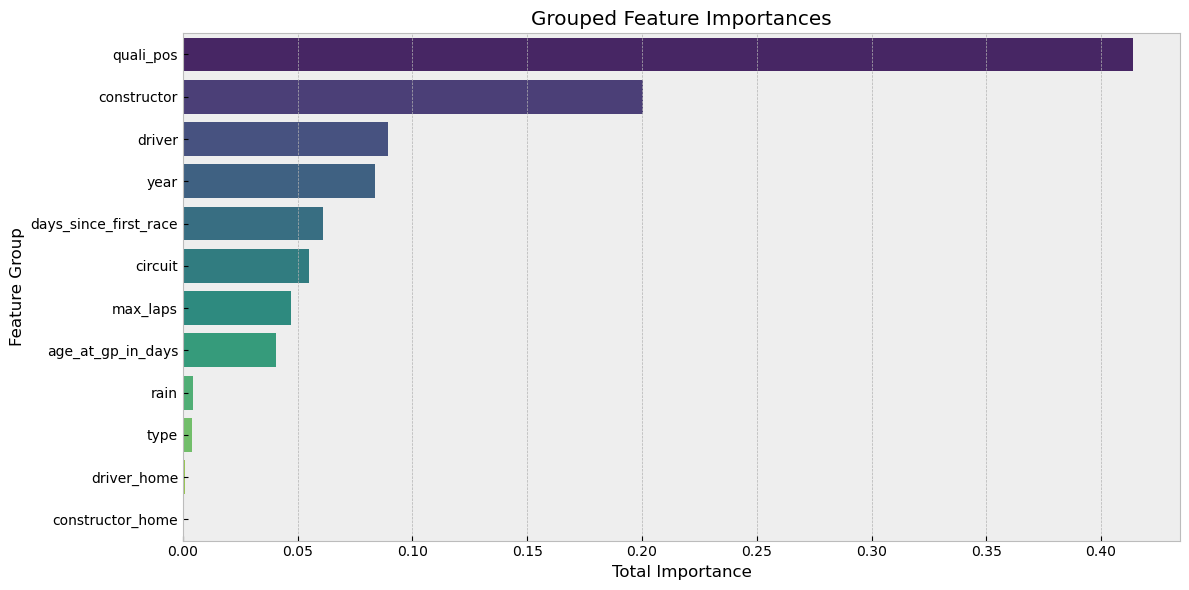

In [ ]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

# Get preprocessor and trained model
preprocessor = best_pipeline.named_steps['preprocessing']
model = best_pipeline.named_steps['model']

# Extract feature names after preprocessing
# 1. Numeric feature names (not transformed)
num_features = num_cols

# 2. Categorical one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)

# 3. Combine both
feature_names = np.concatenate([num_features, cat_features])

# 4. Extract feature importances from the model
importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [ ]:
# save
with open('rf.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


<h5>Gradient boost regressor</h5>

In [ ]:
# Split features and target
y = cleaned_data_median['deviation_from_median']
X = cleaned_data_median.drop(columns=['deviation_from_median'])

# Identify column types
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__loss': [ 'huber'],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [ 300, 400],
    'model__min_samples_split': [ 5, 10, 15],
    'model__min_samples_leaf': [ 4, 5],
    'model__max_depth': [ 4, 5],
}

# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X, y)


# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")



Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RMSE: 89.46023855369367
Final Model Performance:
MSE: 7135.10
RMSE: 84.47
R2: 0.4016
MAE: 25.27


/tmp/ipykernel_2347/2472914946.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


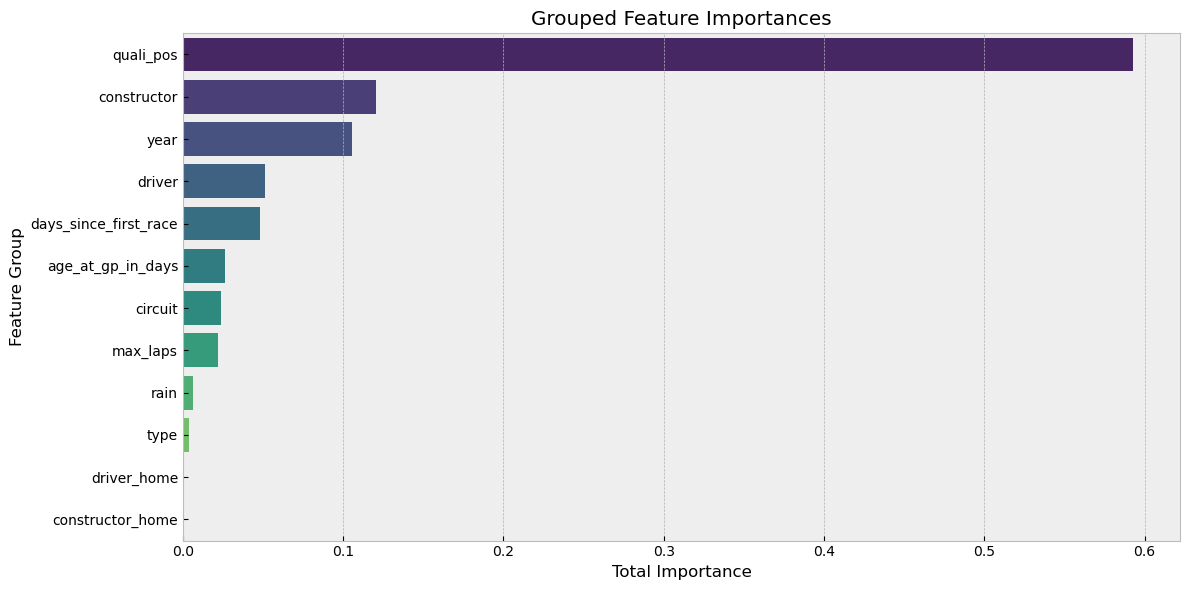

In [ ]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

# Get preprocessor and trained model
preprocessor = best_pipeline.named_steps['preprocessing']
model = best_pipeline.named_steps['model']

# Extract feature names after preprocessing
# 1. Numeric feature names (not transformed)
num_features = num_cols

# 2. Categorical one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)

# 3. Combine both
feature_names = np.concatenate([num_features, cat_features])

# 4. Extract feature importances from the model
importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [ ]:
# save
with open('gb.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>Neural network</h5>

In [ ]:
# Split features and target
y = cleaned_data_median['deviation_from_median']
X = cleaned_data_median.drop(columns=['deviation_from_median'])

# Identify column types
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessor: OHE for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', MLPRegressor(random_state=42))
])

param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01],
    'model__solver': ['adam'],
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X, y)



print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_nn = grid_search.best_estimator_
y_pred = best_model_nn.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/linh/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/linh/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/linh/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/linh/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/linh/anaconda3/lib/python3.12/site-pac

Best Parameters: {'model__activation': 'tanh', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.001, 'model__solver': 'adam'}
Best RMSE: 91.53836234931201
Final Model Performance:
MSE: 6854.45
RMSE: 82.79
R2: 0.4251
MAE: 28.40


/home/linh/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# save
with open('nn.pkl','wb') as f:
    pickle.dump(best_model_nn,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)